## Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.datasets.folder as fold

from PIL import Image
import os
import os.path


%matplotlib inline

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

All hyper parameters go in the next block

In [2]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform, loader=fold.default_loader):
        classes, class_to_idx = fold.find_classes(root_dir)
        imgs = fold.make_dataset(root_dir, class_to_idx)
        
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root_dir + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root_dir
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
Train images
Test images


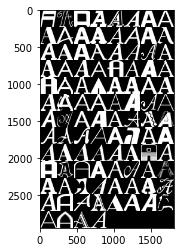

In [4]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='notMNIST_small/train/', train=True, transform=composed_transform, loader=fold.default_loader) # Supply proper root_dir
test_dataset = CDATA(root_dir='notMNIST_small/test/', train=False, transform=composed_transform, loader=fold.default_loader) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [5]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

for param in resnet18.parameters():
    param.requires_grad = False
    
# print(vgg16)

# Code to change the last layers so that they only have 10 classes as output
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

for param in vgg16.classifier.parameters():
    param.requires_grad = True

for param in resnet18.fc.parameters():
    param.requires_grad = True

# Add code for using CUDA here if it is available

Define loss functions and optimizers

In [6]:
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer_vgg16 = torch.optim.Adam(vgg16.classifier.parameters(), lr=learning_rate) # Use Adam optimizer, use learning_rate hyper parameter
optimizer_resnet18 = torch.optim.Adam(resnet18.fc.parameters(), lr=learning_rate) # Use Adam optimizer, use learning_rate hyper parameter


#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [7]:
# Train/finetune the VGG-16 network
# Store the losses for every epoch and generate a graph using matplotlib

def train_vgg16(model=vgg16,size=len(train_dataset),epochs=num_epochs,optimizer=optimizer_vgg16):
    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        running_corrects = 0
        
        for data in train_loader:
            images, labels = data
            images = Variable(images)
            labels = Variable(labels)            
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels) 
            loss.backward()
            optimizer.step()
            
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        plt.plot(epoch,epoch_loss,'g^')
    plt.xlabel('Epoch count', fontsize=14, color='black')
    plt.ylabel('Loss after each epoch', fontsize=14, color='black')
    plt.show()


def train_resnet18(model=resnet18,size=len(train_dataset),epochs=num_epochs,optimizer=optimizer_resnet18):
    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        running_corrects = 0
        
        for data in train_loader:
            images, labels = data
            images, labels = images, labels
            images = Variable(images)
            labels = Variable(labels)            
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels) 
            loss.backward()
            optimizer.step()
            
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        plt.plot(epoch,epoch_loss,'g^')
    plt.xlabel('Epoch count', fontsize=14, color='black')
    plt.ylabel('Loss after each epoch', fontsize=14, color='black')
    plt.show()

Now let us start the training/finetuning

Loss: 0.0111 Acc: 0.6941
Loss: 0.0064 Acc: 0.8291
Loss: 0.0054 Acc: 0.8494
Loss: 0.0049 Acc: 0.8613
Loss: 0.0046 Acc: 0.8697


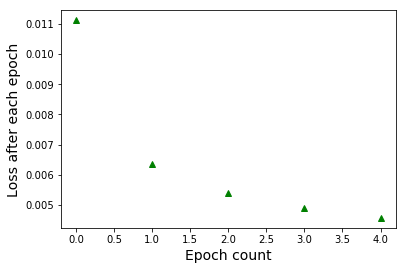

CPU times: user 4h 11min 22s, sys: 13h 29min 59s, total: 17h 41min 22s
Wall time: 3h 32min 13s


In [8]:
# %time train_vgg16()
%time train_resnet18()

#### Testing
Once finetuning is done we need to test it on the test set.

In [9]:
def test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        images = Variable(images)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Acuuracy: %f' %(100 * correct/total))
    

Test the models

In [10]:
# %time test(vgg16)
%time test(resnet18)

Acuuracy: 34.117647
CPU times: user 5min 36s, sys: 19min 16s, total: 24min 53s
Wall time: 4min 57s


You can add more code to save the models if you want but otherwise this notebook is complete